In [9]:
import numpy as np
from scipy.optimize import minimize

class Child:
    def __init__(self, age, height_for_age, mortality):
        self.age = age
        self.height_for_age = np.random.normal(-2, 1) 
        self.mortality = mortality

class Population:
    def __init__(self, num_children):
        self.children = [Child(np.random.uniform(0, 5), 0, np.random.uniform(0, 0.1)) for _ in range(num_children)]

class Intervention:
    def __init__(self, name, cost, effectiveness, effect_on_height, effect_on_mortality):
        self.name = name
        self.cost = cost
        self.effectiveness = effectiveness
        self.effect_on_height = effect_on_height
        self.effect_on_mortality = effect_on_mortality

class OptimaModel:
    def __init__(self, population, interventions, budget):
        self.population = population
        self.interventions = interventions
        self.budget = budget

    def objective(self, coverage):
        total_cost = sum(intervention.cost * cov for intervention, cov in zip(self.interventions, coverage))

        for child in self.population.children:
            child.height_for_age = np.random.normal(-2, 1)

        for intervention, cov in zip(self.interventions, coverage):
            for child in self.population.children:
                if np.random.rand() < intervention.effectiveness * cov:
                    child.height_for_age += intervention.effect_on_height
                    child.mortality += intervention.effect_on_mortality

        total_mortality = sum(child.mortality for child in self.population.children)
        total_stunting = sum(1 for child in self.population.children if child.height_for_age < -2)

        return total_cost + total_mortality + total_stunting

    def optimize(self):
        initial_guess = np.random.uniform(0, 1, len(self.interventions)) 
        initial_guess /= np.sum(initial_guess)
        bounds = [(0, 1)] * len(self.interventions)
        constraints = {'type': 'eq', 'fun': lambda x: sum(x) - 1}
        result = minimize(self.objective, initial_guess, bounds=bounds, constraints=constraints, method='SLSQP')
        return result


AMS = Intervention("Antenatal micronutrient supplementation", cost=50, effectiveness=0.6, effect_on_height=0.2, effect_on_mortality=-0.1)
PEPS = Intervention("Protein-energy supplementation", cost=100, effectiveness=0.5, effect_on_height=0.1, effect_on_mortality=-0.05)
Breastfeeding = Intervention("Breastfeeding promotion", cost=70, effectiveness=0.7, effect_on_height=0.3, effect_on_mortality=-0.2)
IYCF = Intervention("Infant and young child feeding program", cost=80, effectiveness=0.4, effect_on_height=0.1, effect_on_mortality=-0.1)
PPCF = Intervention("Public provision of complementary foods", cost=90, effectiveness=0.5, effect_on_height=0.2, effect_on_mortality=-0.15)
VitaminA = Intervention("Vitamin A supplementation", cost=30, effectiveness=0.6, effect_on_height=0.1, effect_on_mortality=-0.1)

population = Population(1000)  


budget = 100000  
model = OptimaModel(population, [AMS, PEPS, Breastfeeding, IYCF, PPCF, VitaminA], budget)


result = model.optimize()


for i, intervention in enumerate(model.interventions):
    for child in model.population.children:
        child.height_for_age += intervention.effect_on_height * result.x[i]
        child.mortality += intervention.effect_on_mortality * result.x[i]

for i, intervention in enumerate(model.interventions):
    print(f"Optimal coverage for {intervention.name}: {result.x[i]}")

total_mortality = sum(child.mortality for child in model.population.children)
total_stunting = sum(1 for child in model.population.children if child.height_for_age < -2)

print(f"Total mortality: {total_mortality}")
print(f"Total number of stunted children: {total_stunting}")


Optimal coverage for Antenatal micronutrient supplementation: 0.01795889428468933
Optimal coverage for Protein-energy supplementation: 0.19419675652722207
Optimal coverage for Breastfeeding promotion: 0.07663324375744882
Optimal coverage for Infant and young child feeding program: 0.2459396030570465
Optimal coverage for Public provision of complementary foods: 0.23919779924517015
Optimal coverage for Vitamin A supplementation: 0.22607370312842315
Total mortality: -466.10611454333383
Total number of stunted children: 405


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

N = 10000
population = pd.DataFrame({
    'age': np.random.randint(15, 49, N),  
    'BMI': np.random.normal(20, 5, N),  
})

effect_IFA = np.random.normal(0.1, 0.01, N)
effect_MMS = np.random.normal(0.4, 0.02, N)
effect_BEP = np.random.normal(0.55, 0.015, N)
cost_IFA = np.random.normal(100, 10, N)
cost_MMS = np.random.normal(300, 30, N)
cost_BEP = np.random.normal(500, 50, N)

#Their scenarios
scenarios = {
    'baseline': {
        'IFA_supplement': np.random.choice([0, 1], N, p=[0.5, 0.5]),
        'MMS_supplement': np.zeros(N),
        'BEP_supplement': np.zeros(N),
    },
    'universal_MMS': {
        'IFA_supplement': np.zeros(N),
        'MMS_supplement': np.random.choice([0, 1], N, p=[0.1, 0.9]),
        'BEP_supplement': np.zeros(N),
    },
    'universal_BEP': {
        'IFA_supplement': np.zeros(N),
        'MMS_supplement': np.zeros(N),
        'BEP_supplement': np.random.choice([0, 1], N, p=[0.1, 0.9]),
    },
    'MMS_targeted_BEP': {
        'IFA_supplement': np.zeros(N),
        'MMS_supplement': (population['BMI'] >= 18.5).astype(int),
        'BEP_supplement': (population['BMI'] < 18.5).astype(int),
    },
}

#This is wierd way of writing a code, LATERA!
for scenario, interventions in scenarios.items():
    population[scenario + '_effect'] = (interventions['IFA_supplement']*effect_IFA + 
                                        interventions['MMS_supplement']*effect_MMS + 
                                        interventions['BEP_supplement']*effect_BEP)
    population[scenario + '_cost'] = (interventions['IFA_supplement']*cost_IFA + 
                                      interventions['MMS_supplement']*cost_MMS + 
                                      interventions['BEP_supplement']*cost_BEP)
    #This is oversimplfied representation of DALY (in actual work it will not be calculated or presented as such)
    population[scenario + '_DALYs_averted'] = (70 - population['age']) * population[scenario + '_effect']
    population[scenario + '_cost_per_DALY_averted'] = population[scenario + '_cost'] / population[scenario + '_DALYs_averted']


for scenario in scenarios.keys():
    if scenario != 'baseline':
        population[scenario + '_ICER'] = ((population[scenario + '_cost'] - population['baseline_cost']) /
                                           (population[scenario + '_DALYs_averted'] - population['baseline_DALYs_averted']))

population = population.replace([np.inf, -np.inf], np.nan).dropna()

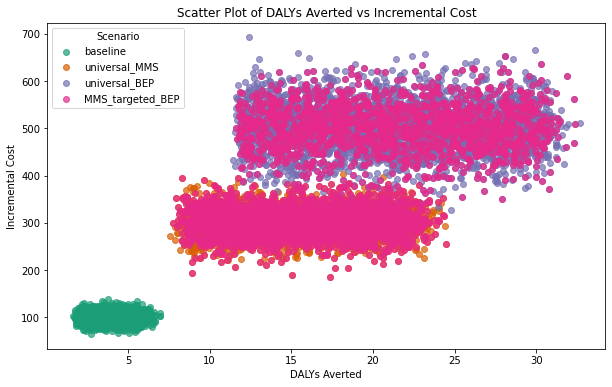

In [11]:
#My plot
colors = sns.color_palette('Dark2', len(scenarios))
plt.figure(figsize=(10, 6))
for i, (scenario, _) in enumerate(scenarios.items()):
    plt.scatter(population[scenario + '_DALYs_averted'], population[scenario + '_cost'],
                color=colors[i], alpha=0.7, label=scenario)
plt.xlabel('DALYs Averted')
plt.ylabel('Incremental Cost')
plt.title('Scatter Plot of DALYs Averted vs Incremental Cost')
plt.legend(title='Scenario')
plt.show()